**Implémentation de la Prédiction Conforme
Application au California Housing**

Initialisation du projet...
Aperçu des données:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  PRICE  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  

Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   206

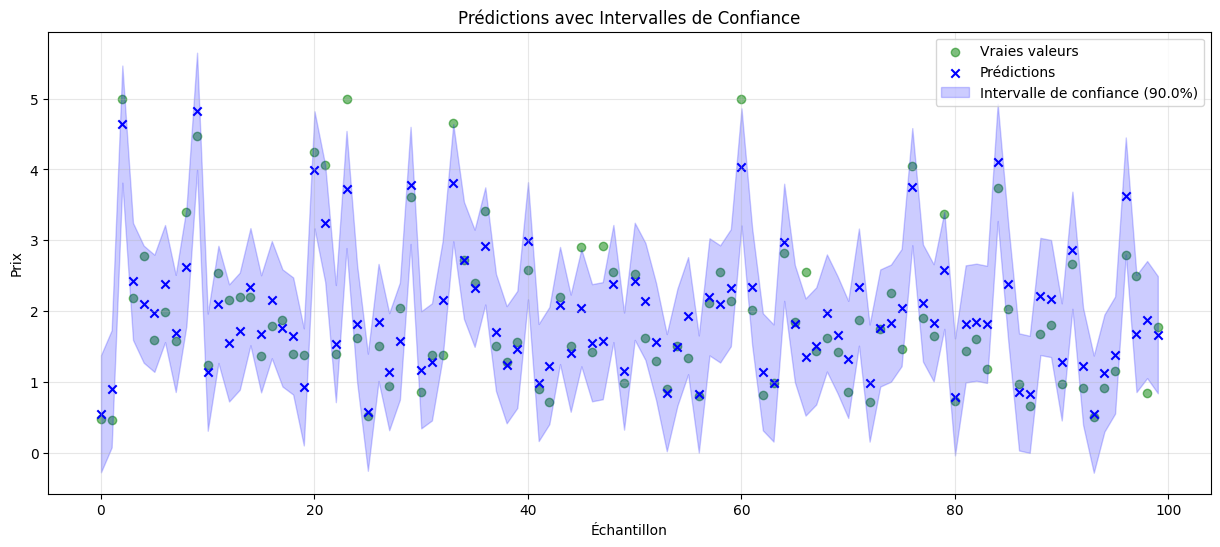

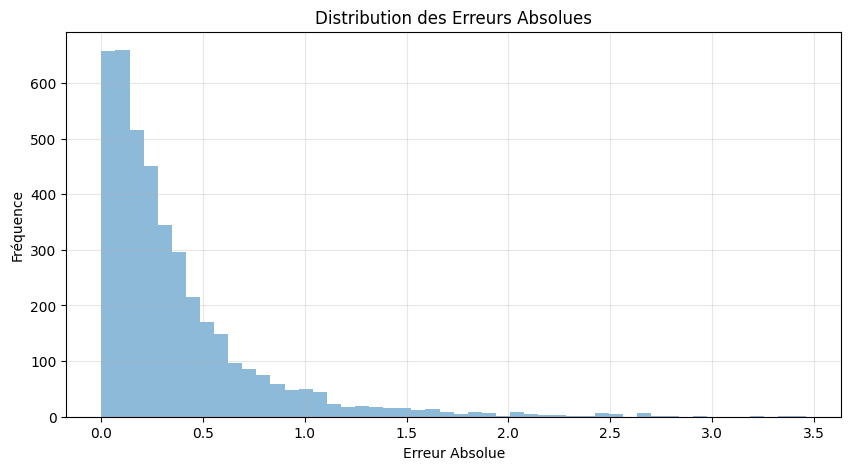

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

class ConformePredictionProject:
    def __init__(self, alpha=0.1):
        # Chargons le dataset
        self.housing = fetch_california_housing()
        self.alpha = alpha

        # Convertissons en DataFrame
        self.df = pd.DataFrame(self.housing.data, columns=self.housing.feature_names)
        self.df['PRICE'] = self.housing.target

        # Initialisons le scaler
        self.scaler = StandardScaler()

        print("Aperçu des données:")
        print(self.df.head())
        print("\nInformations sur le dataset:")
        print(self.df.info())

    def prepare_data(self, test_size=0.2, calib_size=0.25):
        # Séparons features et target
        X = self.df.drop('PRICE', axis=1)
        y = self.df['PRICE']

        # Premier split pour ensemble de test
        X_temp, self.X_test, y_temp, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        # Second split pour calibration
        self.X_train, self.X_calib, self.y_train, self.y_calib = train_test_split(
            X_temp, y_temp, test_size=calib_size, random_state=42
        )

        # Standardisation
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_calib_scaled = self.scaler.transform(self.X_calib)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        return {
            'X_train': self.X_train_scaled, 'y_train': self.y_train,
            'X_calib': self.X_calib_scaled, 'y_calib': self.y_calib,
            'X_test': self.X_test_scaled, 'y_test': self.y_test
        }

    def train_base_model(self, X_train, y_train):
        self.model = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42
        )
        self.model.fit(X_train, y_train)
        return self.model

    def compute_conformity_scores(self, model, X_calib, y_calib):
        calib_preds = model.predict(X_calib)
        self.conformity_scores = np.abs(y_calib - calib_preds)
        return self.conformity_scores

    def get_prediction_intervals(self, model, X_new, conformity_scores):
        predictions = model.predict(X_new)
        q = np.quantile(conformity_scores, 1 - self.alpha)

        lower_bounds = predictions - q
        upper_bounds = predictions + q

        return predictions, lower_bounds, upper_bounds

    def evaluate_predictions(self, y_true, predictions, lower_bounds, upper_bounds):
        coverage = np.mean((y_true >= lower_bounds) & (y_true <= upper_bounds))
        avg_width = np.mean(upper_bounds - lower_bounds)

        metrics = {
            'coverage': coverage,
            'avg_width': avg_width,
            'mse': np.mean((y_true - predictions) ** 2),
            'mae': np.mean(np.abs(y_true - predictions))
        }

        print("\nMétriques d'évaluation:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.3f}")

        return metrics

    def plot_results(self, y_true, predictions, lower_bounds, upper_bounds, sample_size=100):
        # Prennos un échantillon des premiers points
        n = min(sample_size, len(y_true))

        plt.figure(figsize=(15, 6))
        x = np.arange(n)

        # Traçons les vraies valeurs
        plt.scatter(x, y_true[:n], color='green', alpha=0.5, label='Vraies valeurs')

        # Traçons les prédictions
        plt.scatter(x, predictions[:n], color='blue', marker='x', label='Prédictions')

        # Traçons les intervalles
        plt.fill_between(x,
                        lower_bounds[:n],
                        upper_bounds[:n],
                        alpha=0.2,
                        color='blue',
                        label=f'Intervalle de confiance ({(1-self.alpha)*100}%)')

        plt.title('Prédictions avec Intervalles de Confiance')
        plt.xlabel('Échantillon')
        plt.ylabel('Prix')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Plot de la distribution des erreurs
        plt.figure(figsize=(10, 5))
        plt.hist(np.abs(y_true - predictions), bins=50, alpha=0.5)
        plt.title('Distribution des Erreurs Absolues')
        plt.xlabel('Erreur Absolue')
        plt.ylabel('Fréquence')
        plt.grid(True, alpha=0.3)
        plt.show()

def main():
    # Initialisons le projet
    print("Initialisation du projet...")
    cp_project = ConformePredictionProject(alpha=0.1)

    # Préparons les données
    print("\nPréparation des données...")
    data = cp_project.prepare_data()

    # Entraînons le modèle
    print("\nEntraînement du modèle...")
    model = cp_project.train_base_model(data['X_train'], data['y_train'])

    # Calculons les scores de conformité
    print("\nCalcul des scores de conformité...")
    conf_scores = cp_project.compute_conformity_scores(
        model, data['X_calib'], data['y_calib']
    )

    # Faisons des prédictions avec intervalles
    print("\nCalcul des intervalles de prédiction...")
    preds, lower, upper = cp_project.get_prediction_intervals(
        model, data['X_test'], conf_scores
    )

    # Évaluons les résultats
    print("\nÉvaluation des résultats...")
    results = cp_project.evaluate_predictions(
        data['y_test'], preds, lower, upper
    )

    # Visualisons le tout
    print("\nCréation des graphiques...")
    cp_project.plot_results(
        data['y_test'], preds, lower, upper
    )

if __name__ == "__main__":
    main()

**Prédiction Conforme pour la Classification Multiclasse\\
       Application au Dataset Iris**

Initialisation du projet...
Aperçu des données:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  

Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non

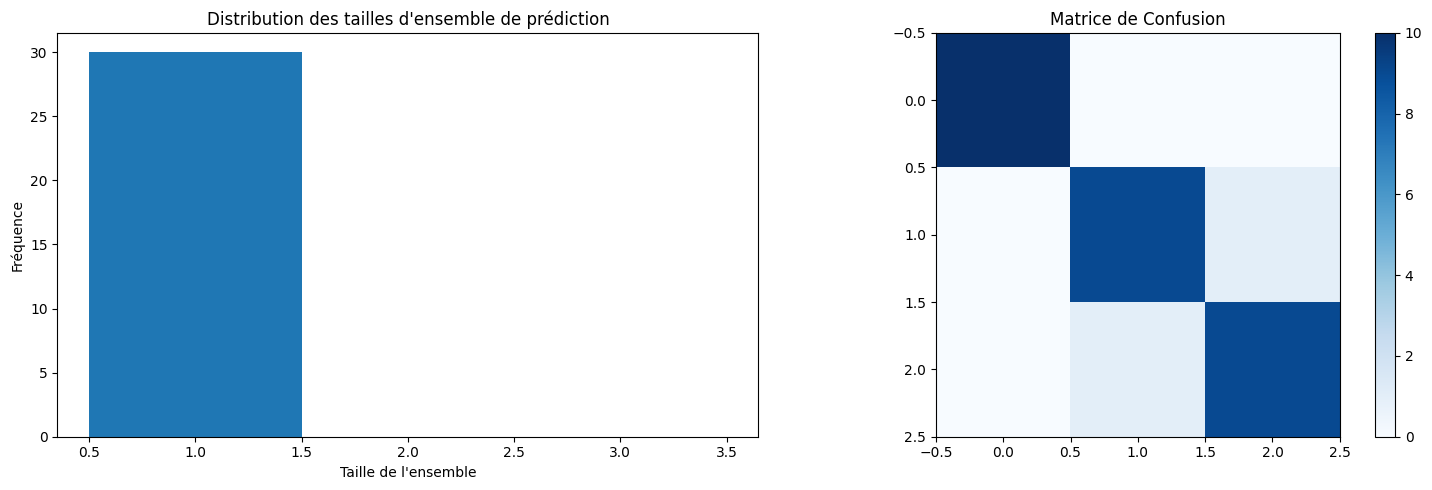

In [14]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

class ConformalClassificationProject:
    def __init__(self, alpha=0.1):
        # Charger le dataset Iris
        self.iris = load_iris()
        self.df = pd.DataFrame(self.iris.data, columns=self.iris.feature_names)
        self.df['target'] = self.iris.target

        self.alpha = alpha
        self.scaler = StandardScaler()

        print("Aperçu des données:")
        print(self.df.head())
        print("\nInformations sur le dataset:")
        print(self.df.info())
        print("\nDistribution des classes:")
        print(self.df['target'].value_counts())

    def prepare_data(self, test_size=0.2, calib_size=0.25):
        # Séparer features et target
        X = self.df.drop('target', axis=1)
        y = self.df['target']

        # Premier split pour ensemble de test
        X_temp, self.X_test, y_temp, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        # Second split pour calibration
        self.X_train, self.X_calib, self.y_train, self.y_calib = train_test_split(
            X_temp, y_temp, test_size=calib_size, random_state=42, stratify=y_temp
        )

        # Standardisation
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_calib_scaled = self.scaler.transform(self.X_calib)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        return {
            'X_train': self.X_train_scaled, 'y_train': self.y_train,
            'X_calib': self.X_calib_scaled, 'y_calib': self.y_calib,
            'X_test': self.X_test_scaled, 'y_test': self.y_test
        }

    def train_base_model(self, X_train, y_train):
        self.model = RandomForestClassifier(
            n_estimators=100,
            max_depth=5,
            random_state=42
        )
        self.model.fit(X_train, y_train)
        return self.model

    def compute_conformity_scores(self, model, X_calib, y_calib):
        # Obtenir les probabilités de prédiction pour chaque classe
        proba_pred = model.predict_proba(X_calib)

        # Calculer les scores de non-conformité (1 - prob de la vraie classe)
        conformity_scores = []
        for i, y_true in enumerate(y_calib):
            conformity_scores.append(1 - proba_pred[i, y_true])

        return np.array(conformity_scores)

    def get_prediction_sets(self, model, X_new, conformity_scores):
        # Obtenir les probabilités pour les nouvelles données
        probas = model.predict_proba(X_new)

        # Calculer le seuil basé sur les scores de conformité
        threshold = np.quantile(conformity_scores, 1 - self.alpha)

        # Créer les ensembles de prédiction
        prediction_sets = []
        for proba in probas:
            pred_set = [i for i, p in enumerate(proba) if p > (1 - threshold)]
            prediction_sets.append(pred_set)

        return prediction_sets, probas

    def evaluate_predictions(self, y_true, prediction_sets, probas):
        # Calculer la couverture
        coverage = np.mean([y in pred_set for y, pred_set
                          in zip(y_true, prediction_sets)])

        # Calculer la taille moyenne des ensembles de prédiction
        avg_set_size = np.mean([len(pred_set) for pred_set in prediction_sets])

        # Calculer l'exactitude des prédictions ponctuelles
        point_predictions = np.argmax(probas, axis=1)
        accuracy = np.mean(point_predictions == y_true)

        metrics = {
            'coverage': coverage,
            'avg_set_size': avg_set_size,
            'accuracy': accuracy
        }

        print("\nMétriques d'évaluation:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.3f}")

        return metrics

    def plot_results(self, y_true, prediction_sets, probas):
        # Visualisation des ensembles de prédiction
        plt.figure(figsize=(15, 5))

        # Sous-graphique 1: Distribution des tailles d'ensemble
        plt.subplot(1, 2, 1)
        set_sizes = [len(s) for s in prediction_sets]
        plt.hist(set_sizes, bins=range(1, 5), align='left')
        plt.title('Distribution des tailles d\'ensemble de prédiction')
        plt.xlabel('Taille de l\'ensemble')
        plt.ylabel('Fréquence')

        # Sous-graphique 2: Matrice de confusion pour prédictions ponctuelles
        plt.subplot(1, 2, 2)
        point_predictions = np.argmax(probas, axis=1)
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_true, point_predictions)
        plt.imshow(cm, cmap='Blues')
        plt.title('Matrice de Confusion')
        plt.colorbar()

        plt.tight_layout()
        plt.show()

def main():
    # Initialiser le projet
    print("Initialisation du projet...")
    cp_project = ConformalClassificationProject(alpha=0.1)

    # Préparer les données
    print("\nPréparation des données...")
    data = cp_project.prepare_data()

    # Entraîner le modèle
    print("\nEntraînement du modèle...")
    model = cp_project.train_base_model(data['X_train'], data['y_train'])

    # Calculer les scores de conformité
    print("\nCalcul des scores de conformité...")
    conf_scores = cp_project.compute_conformity_scores(
        model, data['X_calib'], data['y_calib']
    )

    # Faire des prédictions avec ensembles
    print("\nCalcul des ensembles de prédiction...")
    pred_sets, probas = cp_project.get_prediction_sets(
        model, data['X_test'], conf_scores
    )

    # Évaluer les résultats
    print("\nÉvaluation des résultats...")
    results = cp_project.evaluate_predictions(
        data['y_test'], pred_sets, probas
    )

    # Visualiser
    print("\nCréation des graphiques...")
    cp_project.plot_results(
        data['y_test'], pred_sets, probas
    )

if __name__ == "__main__":
    main()

**Analyse et Implémentation de la Régression Quantile**

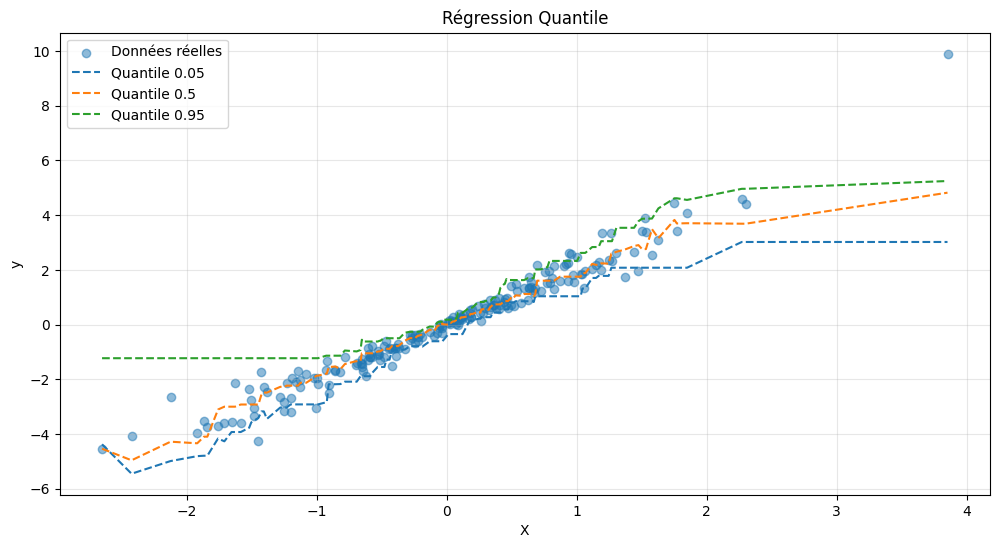


Métriques d'évaluation:
coverage_0.05: 0.075
coverage_0.5: 0.530
coverage_0.95: 0.940


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

class QuantileRegression:
    def __init__(self, quantiles=[0.05, 0.5, 0.95]):
        self.quantiles = quantiles
        self.models = {}
        self.scaler = StandardScaler()

    def fit(self, X, y):
        X_scaled = self.scaler.fit_transform(X)

        for q in self.quantiles:
            model = GradientBoostingRegressor(
                loss='quantile',
                alpha=q,
                n_estimators=100,
                max_depth=4,
                learning_rate=0.1,
                random_state=42
            )
            model.fit(X_scaled, y)
            self.models[q] = model

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        predictions = {}

        for q in self.quantiles:
            predictions[q] = self.models[q].predict(X_scaled)

        return predictions

# Exemple d'utilisation
def main():
    # Générer des données synthétiques
    np.random.seed(42)
    n_samples = 1000

    X = np.random.normal(0, 1, (n_samples, 1))
    # Ajouter de l'hétéroscédasticité
    noise = np.random.normal(0, 0.1 + 0.3 * np.abs(X.ravel()), n_samples)
    y = 2 * X.ravel() + noise

    # Split des données
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Entraîner le modèle
    qr = QuantileRegression(quantiles=[0.05, 0.5, 0.95])
    qr.fit(X_train, y_train)

    # Prédictions
    preds = qr.predict(X_test)

    # Visualisation
    plt.figure(figsize=(12, 6))
    plt.scatter(X_test, y_test, alpha=0.5, label='Données réelles')

    # Tracer les quantiles
    X_plot = np.sort(X_test, axis=0)
    for q in [0.05, 0.5, 0.95]:
        y_plot = preds[q][np.argsort(X_test.ravel())]
        plt.plot(X_plot, y_plot,
                label=f'Quantile {q}',
                linestyle='--')

    plt.title('Régression Quantile')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Évaluation
    def evaluate_quantile_predictions(y_true, predictions, quantiles):
        metrics = {}
        for q in quantiles:
            y_pred = predictions[q]
            # Calculer la couverture empirique
            coverage = np.mean(y_true <= y_pred)
            metrics[f'coverage_{q}'] = coverage

        return metrics

    metrics = evaluate_quantile_predictions(y_test, preds, qr.quantiles)
    print("\nMétriques d'évaluation:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

if __name__ == "__main__":
    main()